<div style="width: 100%; overflow: auto; display: flex; justify-content: space-between; align-items: center;">
<h1 style="margin: 0; font-size: 20px;">Projekt Analityczny #03 - Dashboard</h1>
<img src="Logo_KajoData.png" alt="Logo" style="width: 50px; height: auto; margin-left: auto; margin-right: 0"/>
</div>

### Pytanie biznesowe: 
Kilka tygodni temu umożliwiono zakup kursów w formie subskrypcji (subskrypcję można poznać po cenie - poniżej 50 zł). Wcześniej kursy te były dostępne jedynie w formie jednorazowej płatności na rok lub w ramach KajoDataSpace. Czy był to dobry pomysł? Czy był to zły pomysł? Czy za wcześnie by powiedzieć? Czy można powiedzieć cokolwiek?

### Całą analizę podzielimy na dwa etapy:
1. Zajmiemy się ogólną analizą zmiany przychodów oraz liczby transakcji z uwzględnienim okresów przed możliwością zakupów kursów w formie subskrypji oraz po
2. Natomiast w drugiej części zajmiemy się analizą tych samych aspektów, ale już w kontekście konkretnych produktów - czyli kursów. Na sam koniec sprawdzimy czy aktualne subskrypcje są chętnie przedłużane przez klientów

## EDA 

Pierwszym etapem przygotowania danych było ich wczytanie z plików txt i transformacja danych w PowerQuery - kolejne kroki widczone są w umieszczonych plikach xlsx.
Gotowe pliki xlsx możemy wczytać i przeanalizować za pomocą biblioteki Pandas w Pythonie. Zatem zaimportujmy potrzebne biblioteki i wczytajmy dane

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

In [297]:
customers = pd.read_excel("003_customers.xlsx")
transactions = pd.read_excel("003_transactions.xlsx")

In [299]:
customers.head()

,customer,sex,KDS-first-date,KDS-last-date
0,1,f,2024-07-01,2025-04-01
1,2,m,2024-07-01,2025-04-01
2,3,f,2024-07-01,2025-04-01
3,4,m,2024-07-02,2025-03-24
4,5,f,NaT,NaT


In [301]:
transactions.head()

,product_customer,id_order,date,amount,status
0,Kurs Analiza danych w Microsoft Excel,5,2024-07-24,199.0,paid
1,Kurs Analiza danych w Microsoft Excel,6,2024-07-24,199.0,paid
2,Pakiet Kursoow Analiza Danych w Excelu i SQL,7,2024-07-24,399.0,paid
3,Kurs Analiza danych w Microsoft Excel,19,2024-07-24,199.0,paid
4,Pakiet Kursoow Analiza Danych w Excelu i SQL,22,2024-07-24,399.0,paid


Do transakcji dodamy dodatkową kolumnę "transaction_type". Skorzystamy z informacji, że subskrypcje można poznać po kwocie poniżej 50 złotych.
Dzięki temu łatwo zidentyfikujemy, która transakcja była subskrypcją, a która jednorazowym zakupem kursu. Ułatwi nam to dalszą analizę 

In [303]:
transactions['transaction_type'] = np.where(
    transactions['amount'] < 50, 'Subscription', 'One-Time Payment'
)

In [305]:
print(transactions['transaction_type'].value_counts())

transaction_type
One-Time Payment    357
Subscription        247
Name: count, dtype: int64


In [307]:
transactions.head()

,product_customer,id_order,date,amount,status,transaction_type
0,Kurs Analiza danych w Microsoft Excel,5,2024-07-24,199.0,paid,One-Time Payment
1,Kurs Analiza danych w Microsoft Excel,6,2024-07-24,199.0,paid,One-Time Payment
2,Pakiet Kursoow Analiza Danych w Excelu i SQL,7,2024-07-24,399.0,paid,One-Time Payment
3,Kurs Analiza danych w Microsoft Excel,19,2024-07-24,199.0,paid,One-Time Payment
4,Pakiet Kursoow Analiza Danych w Excelu i SQL,22,2024-07-24,399.0,paid,One-Time Payment


Dla wszystkich zwróconych transakcji zmienimy kwotę z dodatniej na ujemną - żeby w przyszłości łatwiej liczyć przychód z agregacji za pomocą funkcji sum

In [309]:
rows_to_update = transactions['status'] == 'refunded' 
print(rows_to_update.sum())

if rows_to_update.sum() > 0:
    transactions.loc[rows_to_update, 'amount'] = transactions.loc[rows_to_update, 'amount']* -1

print(transactions[transactions['status'] == "refunded"].head())

5
                                      product_customer  id_order       date  \
122                          Kurs Analiza danych w SQL       286 2024-10-24   
210                          Kurs Analiza danych w SQL       413 2024-11-24   
241                Kurs Analiza danych w języku Python       192 2024-12-24   
257  Kompletny Pakiet Analityczny: Excel + SQL + Py...       501 2024-12-24   
289  Kompletny Pakiet Analityczny: Excel + SQL + Py...       561 2025-01-25   

     amount    status  transaction_type  
122  -269.0  refunded  One-Time Payment  
210  -269.0  refunded  One-Time Payment  
241  -229.0  refunded  One-Time Payment  
257  -549.0  refunded  One-Time Payment  
289  -479.0  refunded  One-Time Payment  


# W pierwszej części odpowiemy sobie na pytania:
- Jak zmieniły się przychody po wprowadzeniu zakupu kursów w formie subskrypcji, a jak wyglądały one przed?
- Jak zmieniła się liczba transakcji po wprowadzeniu zakupu kursów w formie subskrypcji, a jak wyglądały one przed?
- Jak zmieniła się średnia cena zakupu kursu przed okresem subskrypcyjnym i po wprowadzeniu subskrypcji?
- Czy miało to jakiś wpływ na ilość kursantów przystępujących do platformy KajoDataSpace?

## 1.1 Jak zmienił się przychód po wprowadzeniu zakupu kursów w formie subskrypcji?

Żeby to zbadać, najpierw wyznaczymy sobie datę od której zaczęły pojawiać się pierwsze subskrypcje i przeanalizujemy na wykresie przychód miesięczny przed i po wprowadzeniu subsrypcji

In [311]:
subscription_transactions_only = transactions[transactions['transaction_type'] == 'Subscription'].copy()

first_subscription = subscription_transactions_only.nsmallest(1, 'date')
first_subscription_date = first_subscription['date'].iloc[0]
first_customer_with_subscription = first_subscription['id_order'].iloc[0]

In [315]:
print(f'Pierwsza data subskrypcji: {first_subscription_date}')
print(first_customer_with_subscription)

Pierwsza data subskrypcji: 2025-01-25 00:00:00
568


In [319]:
# 1. Przygotowanie danych do wykresu: Suma przychodu (amount) po MIESIĄCU
# Używamy resample('M', on='date') do agregacji po miesiącach na podstawie kolumny 'date'.
# 'M' oznacza koniec miesiąca. Jeśli wolisz początek miesiąca, użyj 'MS'.
monthly_revenue = transactions.resample('MS', on='date')['amount'].sum()

print("\nPrzygotowane miesięczne dane o przychodzie (sumowane do końca miesiąca):")
print(monthly_revenue)


Przygotowane miesięczne dane o przychodzie (sumowane do końca miesiąca):
date
2024-07-01    19216.41
2024-08-01     6764.10
2024-09-01     4413.00
2024-10-01    16958.50
2024-11-01     8241.50
2024-12-01     9620.10
2025-01-01    11084.00
2025-02-01     8850.60
2025-03-01    16002.85
2025-04-01     3840.10
Freq: MS, Name: amount, dtype: float64


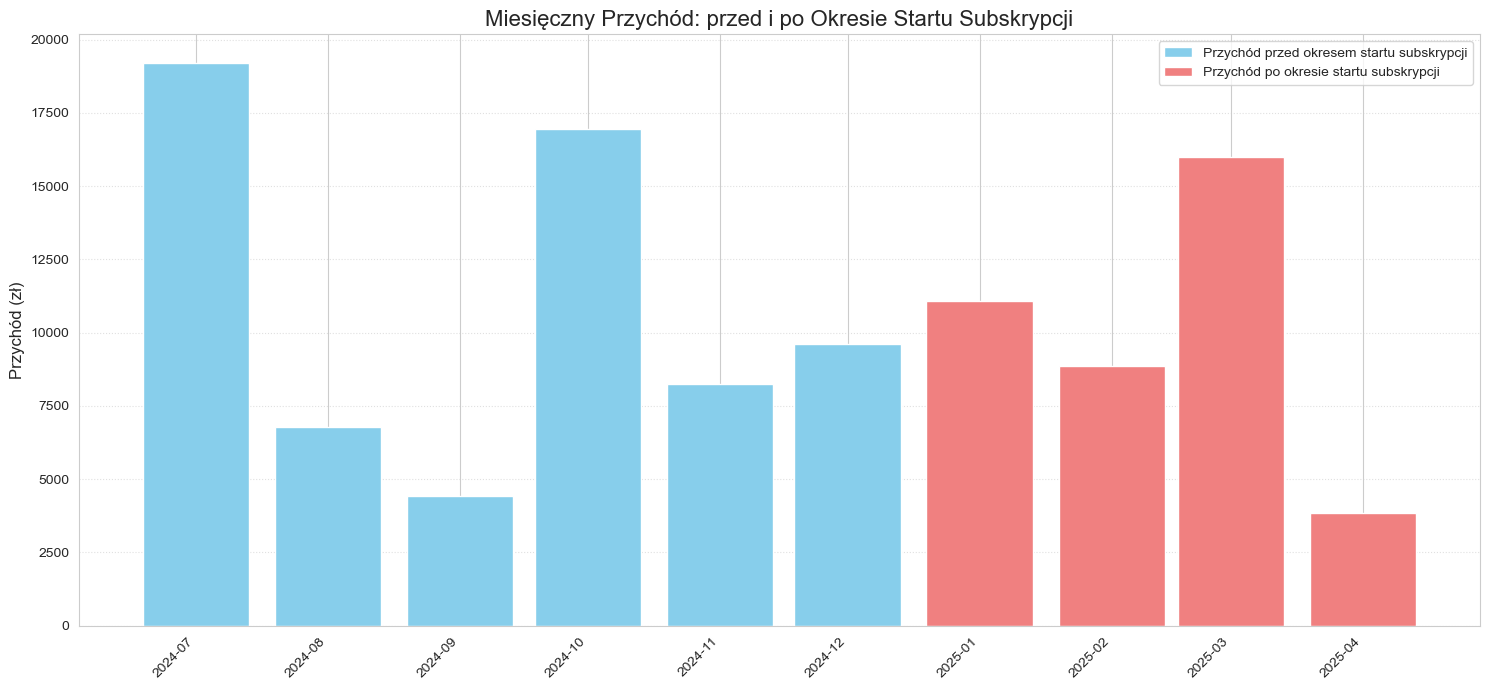

In [321]:
plt.figure(figsize=(15,7))
ax = plt.gca()

color_before = 'skyblue'
color_after = 'lightcoral'

legend_handles = []
added_before_label = False
added_after_label = False
split_date = first_subscription_date

# Iterujemy przez każdy miesiąc w danych
for date, revenue in zip(monthly_revenue.index, monthly_revenue.values):
    
    # Opcja: Miesiąc jest "po", jeśli jego POCZĄTEK jest ON OR AFTER dacie podziału
    # W tym celu porównujemy date.normalize() (początek miesiąca) z split_date.normalize()
    is_after = False
    if split_date is not None:
        month_start = date.normalize().replace(day=1)
        is_after = month_start >= split_date.normalize().replace(day=1) # Porównujemy początki miesięcy
    bar_color = color_before
    label = '_nolegend_' # Domyślnie brak etykiety w legendzie dla każdego słupka

    if is_after:
        bar_color = color_after
        if not added_after_label:
            label = 'Przychód po okresie startu subskrypcji' # Etykieta dla legendy (tylko raz)
            added_after_label = True
    else: #Okres przed lub brak daty podziału
        bar_color = color_before
        if not added_before_label and split_date is not None: # Dodaj etykietę tylko raz, jeśli mamy datę podziału
             label = 'Przychód przed okresem startu subskrypcji'
             added_before_label = True
        elif split_date is None: # Jeśli nie ma daty podziału, wszystkie są "zwykłe"
             if not added_before_label:
                  label = 'Miesięczny Przychód'
                  added_before_label = True
    # Rysujemy słupek dla danego miesiąca z wybranym kolorem i etykietą
    bar_handle = ax.bar(date, revenue, width=25, color=bar_color, label=label)

    # Dodaj uchwyt słupka do listy, jeśli ma etykietę (do legendy)
    if label != '_nolegend_':
         legend_handles.append(bar_handle)

# 3. Dodajemy legendę
if legend_handles: # Pokaż legendę tylko jeśli jakieś etykiety zostały dodane
    ax.legend(handles=legend_handles)

# 4. Formatowanie osi X dla dat miesięcznych
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Dodajemy tytuły i etykiety
plt.title('Miesięczny Przychód: przed i po Okresie Startu Subskrypcji', fontsize=16)
plt.ylabel('Przychód (zł)', fontsize=12)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Na wykresie czerwone słupki oznaczają okres po pojawieniu się możliwości zakupu kursów w formacie subskrypcji. Trzeba jednak pamiętać, że pierwsza subskrypcja przypadła na dzień 25.01.2025 i dlatego też zaznaczona jest kolumna za styczeń. Natomiast pierwszym pełnym miesiącem "subskrypcyjnym" jest luty, w którym widać spadek przychodów - należało się raczej jednak tego sspodziewać, ponieważ ceny subskrypcji są niższe niż wcześniejszych jednorazowych płatności. Natomiast nie jest to duży spadek, a kolejny miesiąc to już ewidentny trend wzrostowy. Słupek za marzec jest wyższy niż te za styczeń czy grudzień - czyli ostatnie miesiące przed wprowadzeniem subskrypcji. 

### Wniosek: 
Wprowadzenie subskrypcji nie miało znaczącego wpływu na przychód w krótkoterminowym okresie. Do tego żeby powiedzieć coś więcej, trzeba poczekać na kolejne miesiące

## 1.2 Jak zmieniła się średnia cena zakupu kursu przed okresem subskrypcyjnym i po wprowadzeniu subskrypcji

In [323]:
transactions_before = transactions[transactions['date'] < first_subscription_date].copy()
transactions_after = transactions[transactions['date'] >= first_subscription_date].copy()

In [325]:
# Statystyki dla okresu PO wprowadzeniu subskrypcji 
mean_before = transactions_after[transactions_after['transaction_type'] == 'One-Time Payment']['amount'].mean()
mean_after = transactions_after[transactions_after['transaction_type'] == 'Subscription']['amount'].mean()

print("--------- Jak zmieniła się średnia cena zakupu po wprowadzeniu subskrypcji? ------")
print(f'\nŚrednia cena zakupu kursu przed okresem subskrypcyjnym: {round(mean_before,2)}')
print(f'Średnia cena zakupu kursu po okresie subskrypcyjnym: {round(mean_after,2)}')

--------- Jak zmieniła się średnia cena zakupu po wprowadzeniu subskrypcji? ------

Średnia cena zakupu kursu przed okresem subskrypcyjnym: 307.18
Średnia cena zakupu kursu po okresie subskrypcyjnym: 39.17


## 1.3 Jak zmieniła się ilość transakcji po wprowadzeniu zakupu kursów w formie subskrypcji?

W tym celu również użyjemy wykresu słupkowego

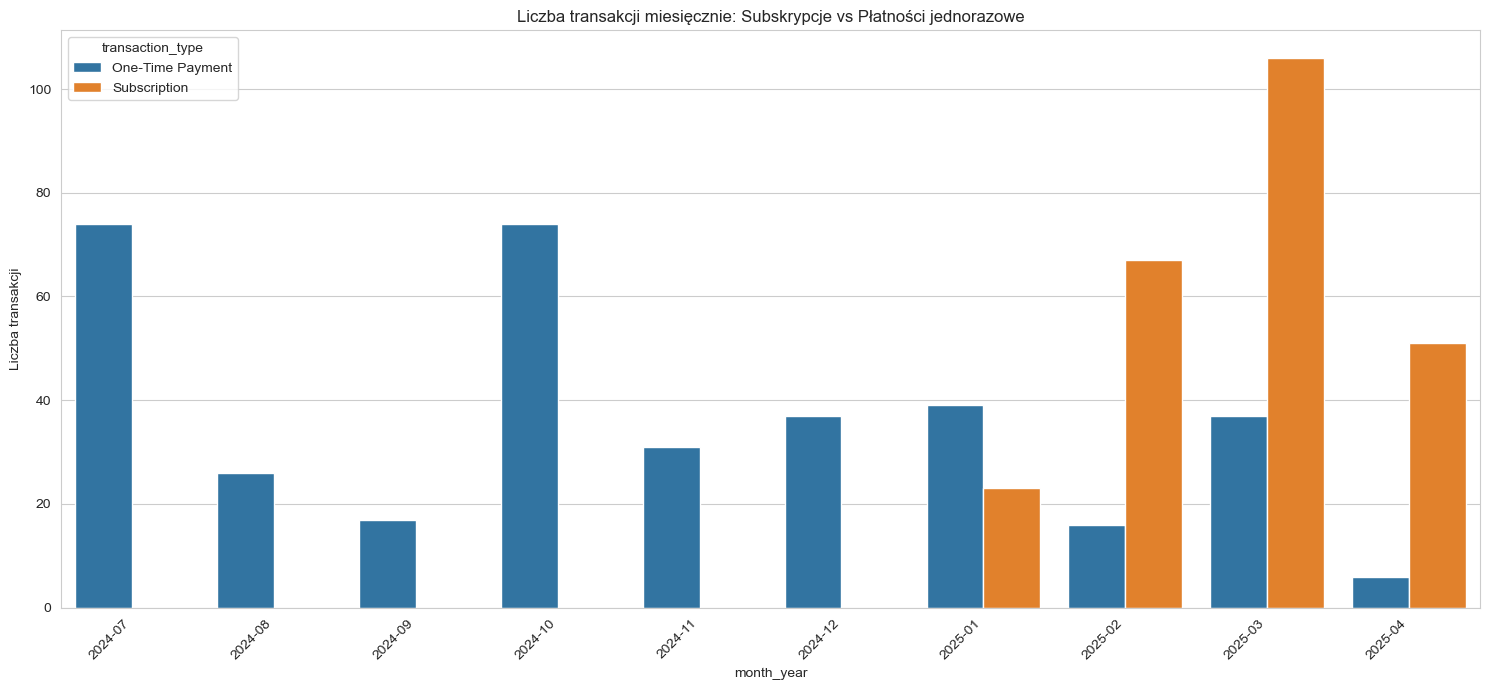

In [327]:
plt.figure(figsize=(15,7))

#Przygotowanie danych 
transactions['month_year'] = transactions['date'].dt.to_period('M')

sns.countplot(data=transactions, x='month_year', hue='transaction_type')
plt.title("Liczba transakcji miesięcznie: Subskrypcje vs Płatności jednorazowe")
plt.ylabel("Liczba transakcji")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
del transactions['month_year']

### Wniosek:
Liczba transakcji subskrypcyjnych znaczenie przerosła transakcje zakupowe jednorazowe. A zatem nawet w krótkoterminowym okresie widoczne jest to, że klienci chętniej wybierali zakup kursów w formie subskrypcji, niż we wcześniejszym okresie zakupy kursów z płatnością jednorazową

## 1.4 Jak to się ma do zakupu dostępu do platformy KajoDataSpace?

Żeby to zbadać, sprawdzimy za pomocą wykresu liniowego skumulowanego jak wygląda liczba klientów KajoDataSpace na przestrzeni całego okresu

In [329]:
# Filtrujemy tylko klientów, którzy mają zarejestrowaną datę pierwszego dostępu (nie NaN/NaT w 'first-date'), pozostali to zakupy kursów
customers_KDS_access = customers.dropna(subset=['KDS-first-date']).copy()
print(f"Liczba klientów w customers z zarejestrowaną datą pierwszego dostępu: {len(customers_KDS_access)}")

Liczba klientów w customers z zarejestrowaną datą pierwszego dostępu: 404


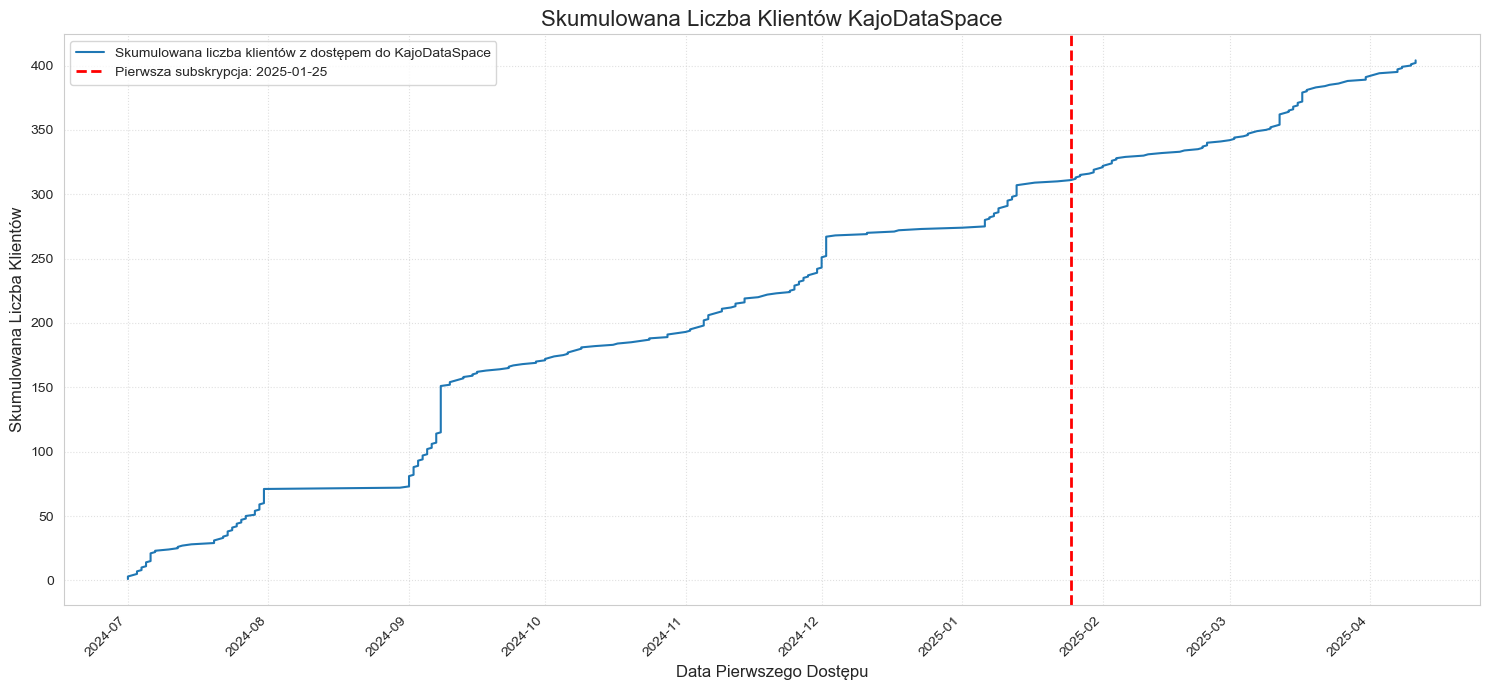

In [331]:
# 1. Przygotowanie danych: Skumulowana liczba nowych klientów
# Usuwamy wiersze z pustą 'first-date'
customers_with_access = customers.dropna(subset=['KDS-first-date']).copy()

if customers_KDS_access.empty:
     print("Brak danych o dacie pierwszego dostępu ('KDS-first-date') dla klientów. Nie można stworzyć wykresu skumulowanego.")
else:
    # Sortujemy klientów według daty pierwszego dostępu
    customers_sorted_by_access_date = customers_KDS_access.sort_values(by='KDS-first-date').reset_index(drop=True)

    # Obliczamy skumulowaną liczbę - tworzymy nową kolumnę 'cumulative_count' - po prostu numeracja wierszy od 1
    customers_sorted_by_access_date['cumulative_count'] = customers_sorted_by_access_date.index + 1

    #print("\nPrzygotowane dane: Klienci posortowani z dodaną kolumną skumulowanej liczby.")
    #print(customers_sorted_by_access_date[['KDS-first-date', 'cumulative_count']].head())
    #print("...")
    #print(customers_sorted_by_access_date[['KDS-first-date', 'cumulative_count']].tail())


    # 2. Tworzenie wykresu liniowego (skumulowanego)
    plt.figure(figsize=(15, 7))
    ax = plt.gca()

    # Rysujemy linię: na osi X daty pierwszego dostępu, na osi Y skumulowana liczba
    ax.plot(customers_sorted_by_access_date['KDS-first-date'], customers_sorted_by_access_date['cumulative_count'], linestyle='-', markersize=4, label='Skumulowana liczba klientów z dostępem do KajoDataSpace')


    # 3. Zaznaczenie momentu pierwszej subskrypcji (jeśli istnieje)
    if first_subscription_date is not None:
        plt.axvline(
            first_subscription_date,  # Pozycja linii na osi X (data)
            color='red',                         # Kolor linii
            linestyle='--',                      # Styl linii (przerywana)
            lw=2,
            label=f'Pierwsza subskrypcja: {first_subscription_date.strftime("%Y-%m-%d")}'
        )

    # 4. Formatowanie osi X (daty)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator()) # Automatyczne lokalizowanie dat
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator())) # Automatyczne formatowanie dat


    # Dodajemy tytuły i etykiety
    ax.set_title('Skumulowana Liczba Klientów KajoDataSpace', fontsize=16)
    ax.set_xlabel('Data Pierwszego Dostępu', fontsize=12)
    ax.set_ylabel('Skumulowana Liczba Klientów', fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.6)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if first_subscription_date is not None:
         plt.legend()


    # 5. Wyświetlenie wykresu
    plt.show()

### Wniosek:
Skumulowany wzrost nowych klientów platformy KajoDataSpace, po okresie wprowadzenia zakupów subskrypcyjnych, nadal jest liniowy. Oznacza to, że w krótkim okresie czasu wprowadzenie subskrypcji nie przekłada się na większy wzrost nowych klientów z dostępem do platformy KajoDataSpace niż do tej pory. Być może na taki efekt trzeba jeszcze poczekać - musimy wziąć pod uwagę, że badany okres "po subskrypcyjny" jest dosyć krótki 

# 2. Analiza poszczególnych produktów 
### W drugiej części naszej analizy zbadamy takie kwestie jak:
- Analiza, który produkt w jakim okresie był najczęściej sprzedawany i jaki stanowi procent przychodu?
- Jak przedstawia się przychód oraz liczba transakcji z podziałem na okresy PRZED i PO wprowadzeniu subskrypcji oraz z podziałem na konkretne produkty?
- Czy klienci przedłużają swoje subskrypcje?

### 2.1 Który produkt i w jakim okresie był najczęściej kupowany i jaki stanowi procent przychodu?
Aby to obliczyć, napiszemy funkcję pomocniczą, a potem wywołamy ją dla okresów: ogółem, przed i po subskrypcyjnym

In [335]:
# --- Funkcja pomocnicza do analizy dla danego DataFrame ---
def analyze_product_revenue(df, period_name):
    """
    Analizuje najczęściej wybierany produkt (wg liczby) i jego procentowy udział w przychodzie dla podanego DataFrame transakcji.
    """

    print(f"\n--- Analiza dla okresu: {period_name} ---")

    # Sprawdzamy, czy DataFrame nie jest pusty
    if df.empty:
        print("DataFrame dla tego okresu jest pusty. Brak danych do analizy.")
        return # Przerywamy działanie funkcji, jeśli danych brak

    # Upewniamy się, że kolumna 'amount' jest numeryczna i braki są traktowane jako 0
    # Dodaję konwersję i fillna(0) w funkcji na wszelki wypadek, ale najlepiej zrobić to raz na początku
    df['amount'] = pd.to_numeric(df['amount'], errors='coerce').fillna(0)

    # Upewniamy się, że kolumna 'product_customer' nie jest pusta po filtrowaniu
    if df['product_customer'].isnull().all():
         print("Kolumna 'product_customer' zawiera tylko braki dla tego okresu.")
         top_product = "Brak danych"
         top_product_count = 0
         revenue_top_product = 0
         total_revenue = df['amount'].sum() # Nadal możemy obliczyć całkowity przychód
    else:
        # 1. Znajdź najczęściej wybierany produkt (ten, który pojawił się najwięcej razy)
        product_counts = df['product_customer'].value_counts()
        top_product = product_counts.index[0] # Index[0] to etykieta najczęstszej wartości
        top_product_count = product_counts.iloc[0] # iloc[0] to liczba wystąpień najczęstszej wartości

        print(f"Najczęściej wybierany produkt (wg liczby transakcji): '{top_product}' (Liczba transakcji: {top_product_count})")

        # 2. Oblicz przychód wygenerowany przez ten produkt
        # Filtrujemy DataFrame, żeby zostawić tylko transakcje tego produktu i sumujemy 'amount'
        revenue_top_product = df[df['product_customer'] == top_product]['amount'].sum()

        # 3. Oblicz całkowity przychód w tym okresie
        total_revenue = df['amount'].sum()

    # 4. Oblicz procent przychodu z najczęściej wybieranego produktu
    percentage_of_revenue = (revenue_top_product / total_revenue) * 100 if total_revenue > 0 else 0

    print(f"Przychód z produktu '{top_product}': {revenue_top_product:.2f} zł")
    print(f"Całkowity przychód w tym okresie: {total_revenue:.2f} zł")
    print(f"Procent przychodu z produktu '{top_product}': {percentage_of_revenue:.2f}%")
    print("-" * 30) # Separator dla czytelności

#### Teraz używając tej funkcji obliczymy te statystyki z podziałem na okresy przed subskrypcjami i po

In [337]:
# --- Wykonanie analizy dla różnych okresów ---

# Analiza 1: Ogółem (dla całego DataFrame transakcji)
analyze_product_revenue(transactions, "Ogółem (cały okres)")
# Analiza 2 i 3: Z podziałem na okresy PRZED i PO dacie pierwszej subskrypcji
# Sprawdzamy, czy data podziału istnieje
if first_subscription_date is None:
    print("\nData pierwszej subskrypcji nie została znaleziona. Nie można przeprowadzić analizy z podziałem na okresy 'przed' i 'po'.")
else:
    print(f"\nPrzeprowadzanie analizy z podziałem na okresy przed i po dacie: {first_subscription_date.strftime('%Y-%m-%d')}")

    # Okres PRZED: data transakcji jest WCZEŚNIEJSZA (<) niż data podziału
    transactions_before_subscription = transactions[
        transactions['date'] < first_subscription_date
    ].copy()

    # Okres PO: data transakcji jest PÓŹNIEJSZA LUB RÓWNA (>=) dacie podziału
    transactions_after_subscription = transactions[
        transactions['date'] >= first_subscription_date
    ].copy()

    analyze_product_revenue(transactions_before_subscription, f"Przed {first_subscription_date.strftime('%Y-%m-%d')}")
    analyze_product_revenue(transactions_after_subscription, f"Po {first_subscription_date.strftime('%Y-%m-%d')}")


--- Analiza dla okresu: Ogółem (cały okres) ---
Najczęściej wybierany produkt (wg liczby transakcji): 'Kurs Analiza danych w Microsoft Excel' (Liczba transakcji: 204)
Przychód z produktu 'Kurs Analiza danych w Microsoft Excel': 19740.70 zł
Całkowity przychód w tym okresie: 104991.16 zł
Procent przychodu z produktu 'Kurs Analiza danych w Microsoft Excel': 18.80%
------------------------------

Przeprowadzanie analizy z podziałem na okresy przed i po dacie: 2025-01-25

--- Analiza dla okresu: Przed 2025-01-25 ---
Najczęściej wybierany produkt (wg liczby transakcji): 'Kurs Analiza danych w SQL' (Liczba transakcji: 66)
Przychód z produktu 'Kurs Analiza danych w SQL': 15289.26 zł
Całkowity przychód w tym okresie: 65213.61 zł
Procent przychodu z produktu 'Kurs Analiza danych w SQL': 23.44%
------------------------------

--- Analiza dla okresu: Po 2025-01-25 ---
Najczęściej wybierany produkt (wg liczby transakcji): 'Kurs Analiza danych w Microsoft Excel' (Liczba transakcji: 143)
Przychód z 

Te dane mogą nam już coś powiedzieć, ale przedstawmy bardziej szczegółowe dane na wykresie. Sprawdzimy statystyki liczby transakcji oraz przychody dla każdego kursu z podziałem na okres:
- przed subskrypcją
- po subskrypcji
- ogółem

Żeby to zrobić będziemy musieli najpierw obliczyć liczbę transakcji dla danego kursu oraz obliczymy przychód dla poszcególnego produktu również z podziałem na przytoczone okresy - zatem odpowiedzmy sobie na pytanie:

### 2.1 Jak przedstawia się przychód oraz liczba transakcji z podziałem na okresy PRZED i PO wprowadzeniu subskrypcji oraz z podziałem na konkretne produkty?

In [339]:
print("\nGenerowanie tabeli statystyk dla każdego produktu, z podziałem na okresy.")

# --- 1. Obliczenia dla okresu OGÓŁEM ---
print("Obliczanie statystyk ogółem...")
overall_stats = transactions.groupby('product_customer').agg(
    Overall_Count=('amount', 'size'),        # Liczba transakcji dla każdego produktu
    Overall_Revenue=('amount', 'sum')         # Całkowity przychód z każdego produktu
).reset_index() # reset_index() zamienia indeks (product_customer) z powrotem na kolumnę

# Oblicz całkowity przychód ogółem (potrzebny do procentów)
total_revenue_overall = overall_stats['Overall_Revenue'].sum()

# --- 2. Obliczenia dla okresów PRZED i PO (jeśli data podziału istnieje) ---
if first_subscription_date is None:
    print("\nData pierwszej subskrypcji nie została znaleziona. Nie można podzielić danych na okresy 'przed' i 'po'.")
    # Jeśli brak daty podziału, statystyki przed/po będą puste
    before_stats = pd.DataFrame(columns=['product_customer', 'Before_Count', 'Before_Revenue'])
    after_stats = pd.DataFrame(columns=['product_customer', 'After_Count', 'After_Revenue'])
    total_revenue_before = 0
    total_revenue_after = 0
else:
    print(f"\nObliczanie statystyk z podziałem na okresy przed i po dacie: {first_subscription_date.strftime('%Y-%m-%d')}...")

    # Filtrowanie DataFramu transakcji na okresy
    transactions_before_subscription = transactions[
        transactions['date'] < first_subscription_date
    ].copy()

    transactions_after_subscription = transactions[
        transactions['date'] >= first_subscription_date
    ].copy()

    # Obliczenia dla okresu PRZED
    if transactions_before_subscription.empty:
         print("Brak transakcji w okresie PRZED. Statystyki dla tego okresu będą puste.")
         before_stats = pd.DataFrame(columns=['product_customer', 'Before_Count', 'Before_Revenue'])
         total_revenue_before = 0
    else:
        before_stats = transactions_before_subscription.groupby('product_customer').agg(
            Before_Count=('amount', 'size'),
            Before_Revenue=('amount', 'sum')
        ).reset_index()
        total_revenue_before = before_stats['Before_Revenue'].sum()

    # Obliczenia dla okresu PO
    if transactions_after_subscription.empty:
        print("Brak transakcji w okresie PO. Statystyki dla tego okresu będą puste.")
        after_stats = pd.DataFrame(columns=['product_customer', 'After_Count', 'After_Revenue'])
        total_revenue_after = 0
    else:
        after_stats = transactions_after_subscription.groupby('product_customer').agg(
            After_Count=('amount', 'size'),
            After_Revenue=('amount', 'sum')
        ).reset_index()
        total_revenue_after = after_stats['After_Revenue'].sum()

# --- 3. Połączenie statystyk do jednej tabeli ---
print("\nŁączenie statystyk do jednej tabeli...")

# Łączymy statystyki ogółem, przed i po, używając kolumny 'product_customer' jako klucza
# how='left' na kolejnych złączeniach gwarantuje, że każdy produkt z listy ogółem się pojawi
# Nawet jeśli nie miał transakcji przed lub po
combined_product_stats = overall_stats.merge(
    before_stats, on='product_customer', how='left'
).merge(
    after_stats, on='product_customer', how='left'
)

# Wypełniamy wartości NaN (które pojawiły się, gdy produkt nie miał transakcji w danym okresie) zerami
combined_product_stats = combined_product_stats.fillna(0)


Generowanie tabeli statystyk dla każdego produktu, z podziałem na okresy.
Obliczanie statystyk ogółem...

Obliczanie statystyk z podziałem na okresy przed i po dacie: 2025-01-25...

Łączenie statystyk do jednej tabeli...



 Generowanie wykresów dla statystyk per produkt i okres.


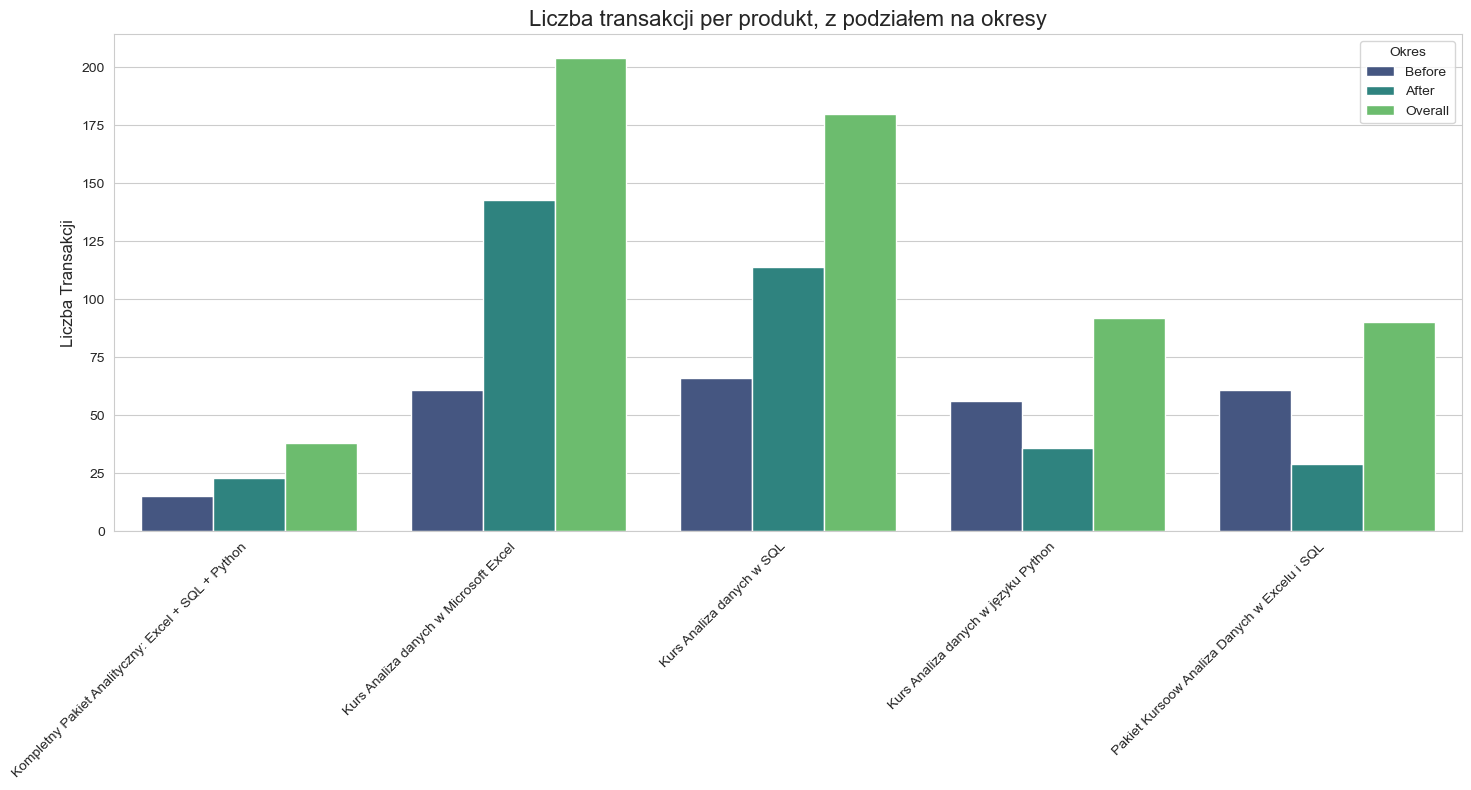

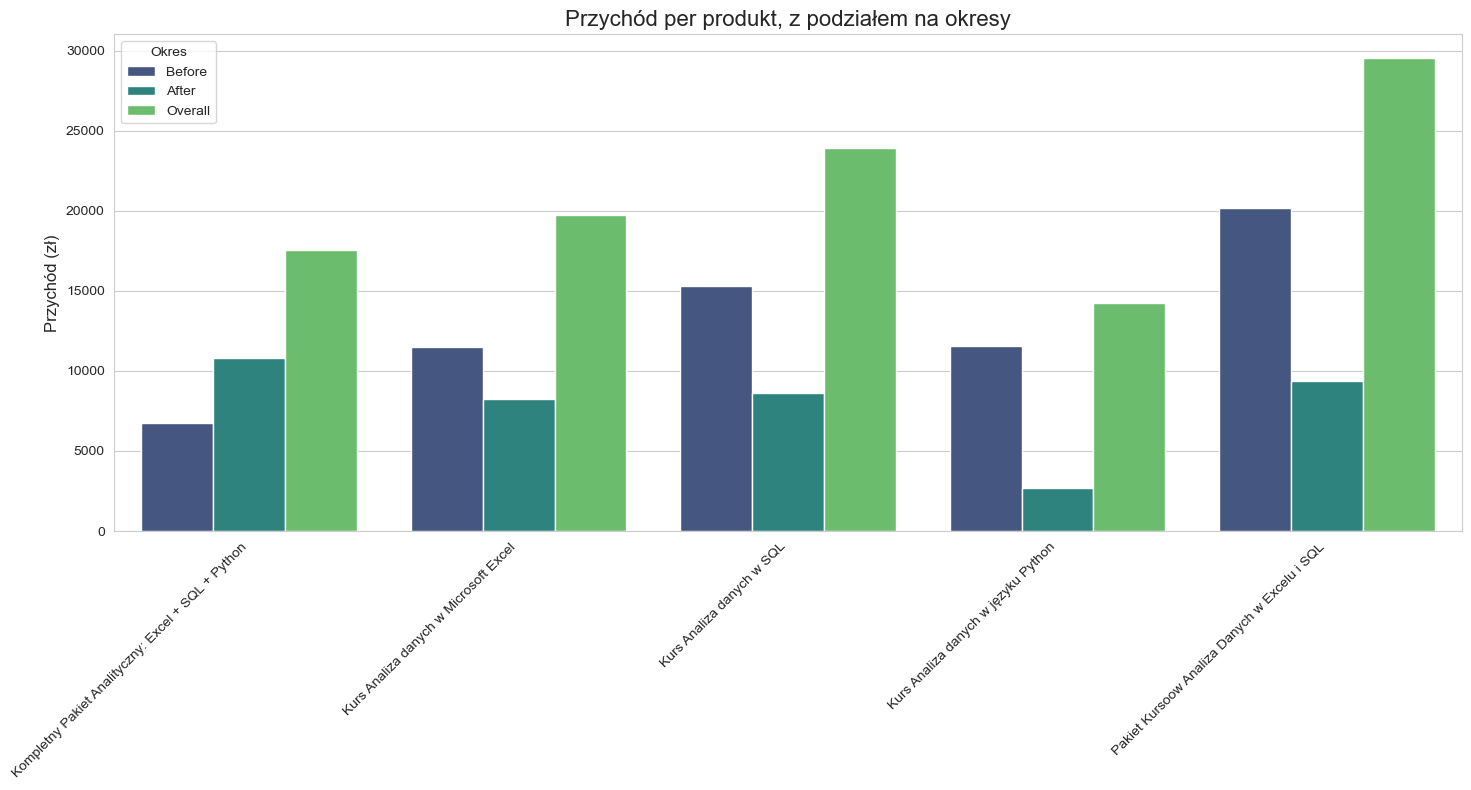

In [354]:
print("\n Generowanie wykresów dla statystyk per produkt i okres.")

if first_subscription_date is None:
    print("Data pierwszej subskrypcji nie została znaleziona. Wykresy z podziałem przed/po nie zostaną wygenerowane.")
else:
    # --- Przygotowanie danych do wykresów grupowych (format "long") ---

    # 1. Wybieramy kolumny z liczbą transakcji i topimy je
    count_cols = ['product_customer', 'Overall_Count', 'Before_Count', 'After_Count']
    # Upewnij się, że kolumny istnieją
    count_cols = [col for col in count_cols if col in combined_product_stats.columns]

    if 'product_customer' in count_cols and len(count_cols) > 1:
        counts_long = combined_product_stats[count_cols].melt(
            id_vars='product_customer', # Kolumna identyfikująca (product)
            var_name='Period',          # Nowa kolumna dla nazw okresów (Overall, Before, After)
            value_name='Count'          # Nowa kolumna dla wartości zliczania
        )
        # Czyścimy nazwy okresów
        counts_long['Period'] = counts_long['Period'].str.replace('_Count', '')
    else:
        # print("Brak kolumn z liczbą transakcji do przetopienia.")
        counts_long = pd.DataFrame() # Empty DataFrame


    # 2. Wybieramy kolumny z przychodem i transformujemy je
    # Pamiętajmy, że kolumny przychodu są teraz stringami ('XXX.XX zł'), musimy je z powrotem skonwertować na numeryczne
    # Użyjemy oryginalnych danych z combined_product_stats przed formatowaniem na stringi LUB skonwertujemy sformatowane stringi z powrotem
    # Lepiej użyć oryginalnych wartości numerycznych przed formatowaniem, jeśli są dostępne.
    # Załóżmy, że oryginalne numeryczne kolumny są potrzebne. Jeśli combined_product_stats zawiera już sformatowane stringi, musimy je oczyścić:
    temp_combined_stats = combined_product_stats.copy()
    for col in ['Overall_Revenue', 'Before_Revenue', 'After_Revenue']:
         if col in temp_combined_stats.columns:
              # Remove ' zł' and convert to float, handling errors/NaNs from original data
              temp_combined_stats[col] = temp_combined_stats[col].astype(str).str.replace(' zł', '').astype(float)

    revenue_cols = ['product_customer', 'Overall_Revenue', 'Before_Revenue', 'After_Revenue']
    revenue_cols = [col for col in revenue_cols if col in temp_combined_stats.columns]

    if 'product_customer' in revenue_cols and len(revenue_cols) > 1: # Need product column and at least one revenue column
        revenue_long = temp_combined_stats[revenue_cols].melt(
            id_vars='product_customer',
            var_name='Period',
            value_name='Revenue'
        )
        # Czyścimy nazwy okresów
        revenue_long['Period'] = revenue_long['Period'].str.replace('_Revenue', '')

    else:
        print("Brak kolumn z przychodem do przetopienia.")
        revenue_long = pd.DataFrame() # Empty DataFrame

    # 3. Łączymy dane o liczbie i przychodzie
    if not counts_long.empty and not revenue_long.empty:
        # Łączymy na 'product_customer' i 'Period'
        combined_long_data = pd.merge(counts_long, revenue_long, on=['product_customer', 'Period'], how='outer')

        # print("\nDane do wykresów grupowych (format long, po połączeniu):")
        # print(combined_long_data.head())
        # print("...")

        desired_period_order = ['Before', 'After', 'Overall']
        # --- Generowanie wykresów grupowych ---
        sns.set_style("whitegrid")

        # Wykres 1: Liczba transakcji per produkt per okres
        plt.figure(figsize=(15, 8))
        sns.barplot(
            x='product_customer',   # Produkty na osi X
            y='Count',              # Liczba na osi Y
            hue='Period',           # Okresy jako grupy (kolory)
            data=combined_long_data,# Dane w formacie long
            palette='viridis',
            hue_order=desired_period_order
        )
        plt.title('Liczba transakcji per produkt, z podziałem na okresy', fontsize=16)
        plt.ylabel('Liczba Transakcji', fontsize=12)
        plt.xlabel("")
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Okres')
        plt.tight_layout()
        plt.show()

        # Wykres 2: Przychód per produkt per okres
        plt.figure(figsize=(15, 8))
        sns.barplot(
            x='product_customer',   # Produkty na osi X
            y='Revenue',            # Przychód na osi Y
            hue='Period',           # Okresy jako grupy (kolory)
            data=combined_long_data,# Dane w formacie long
            palette='viridis',
            hue_order=desired_period_order
        )
        plt.title('Przychód per produkt, z podziałem na okresy', fontsize=16)
        plt.ylabel('Przychód (zł)', fontsize=12)
        plt.xlabel("")
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Okres')
        plt.tight_layout()
        plt.show()

    else:
        print("\nBrak danych do stworzenia wykresów grupowych.")


### Wnioski:
#### a) Dotyczące liczby transakcji
- Najchętniej wybieranymi kursami po wprowadzeniu subskrypcji są kursy dotyczące Excela oraz SQL
- Biorąc pod uwagę to, że okres PO jest krótszy niż okres PRZED, to liczba transakcji dla Excela i SQL bardzo mocno wzrosła
- Za to najmniejsza ilość transakcji po subskrypcji dotyczy kursów Pythona oraz pakietu Excel + SQL

#### b) Dotyczące przychodu
- Jedynym kursem, którego przychody PO przewyższają już przychody PRZED jest kompletny kurs analityczny: Excel + SQL + Python
- Bardzo widoczną różnicą w przychodach między okresem PRZED a PO, jest kurs Pythona - być może należałoby zastanowić się nad jego zareklamowaniem. Z drugiej strony, musimy pamiętać, że badany okres PO jest dosyć krótki, a kurs Pythona może być wybierany jako następny zaraz po Excelu i SQL, co by odpowiadało ścieżce kariery kandydata na Analityka Danych

### 2.3 Czy klienci przedłużają subskrypcje?

Żeby odpowiedzieć sobie na to pytanie zajmiemy się zbadniem samego okresu PO wprowadzeniu subskrypcji. Wyznaczymy unikalną parę produkt-klient (bo przecież jeden klient mógł wykupić dwa kursy w systemie subskrypcjynym ) i sprawdzimy ile razy taka unikalna para już wystąpiła w tabeli transakcje

In [343]:
print("\nAnaliza aktywności klientów per produkt w okresie PO dacie pierwszej subskrypcji.")

if first_subscription_date is None:
    print("Data pierwszej subskrypcji nie została znaleziona. Nie można analizować okresu 'po'.")
    transactions_after = pd.DataFrame() # Pusty DataFrame
else:
    # Tworzymy DataFrame z transakcjami od daty pierwszej subskrypcji włącznie
    transactions_after = transactions[
        (transactions['date'] >= first_subscription_date) &
        (transactions['transaction_type'] == 'Subscription')
    ].copy()

    print(f"\nUtworzono DataFrame z transakcjami PO dacie {first_subscription_date.strftime('%Y-%m-%d')}.")
    print(f"Liczba transakcji w tym okresie: {len(transactions_after)}")


# 2. Sprawdzamy, czy w okresie PO są w ogóle jakieś transakcje
if transactions_after.empty:
    print("Brak transakcji w okresie PO dacie pierwszej subskrypcji. Nie można przeprowadzić analizy per klient per produkt w tym okresie.")

else:
    # 3. Grupowanie i agregacja
    # Grupujemy po ID klienta i nazwie produktu, a następnie obliczamy count, min date, max date
    customer_product_activity_after_split = transactions_after.groupby(['id_order', 'product_customer']).agg(
        Purchase_Count=('date', 'size'), # Liczba transakcji dla tej pary klient-produkt w okresie PO
        First_Purchase_Date=('date', 'min'), # Data pierwszej takiej transakcji w okresie PO
        Last_Purchase_Date=('date', 'max')   # Data ostatniej takiej transakcji w okresie PO
    ).reset_index() # Resetujemy indeks, żeby id_order i product_customer stały się kolumnami

    print("\nWynikowa tabela aktywności klientów per produkt w okresie PO subskrypcji:")
    print(customer_product_activity_after_split.head())
    print("...")
    print(customer_product_activity_after_split.tail())
    print(f"\nLiczba unikalnych par klient-produkt z transakcjami w okresie PO: {len(customer_product_activity_after_split)}")


Analiza aktywności klientów per produkt w okresie PO dacie pierwszej subskrypcji.

Utworzono DataFrame z transakcjami PO dacie 2025-01-25.
Liczba transakcji w tym okresie: 247

Wynikowa tabela aktywności klientów per produkt w okresie PO subskrypcji:
   id_order                       product_customer  Purchase_Count  \
0       190    Kurs Analiza danych w języku Python               2   
1       221              Kurs Analiza danych w SQL               2   
2       284  Kurs Analiza danych w Microsoft Excel               1   
3       549              Kurs Analiza danych w SQL               2   
4       568  Kurs Analiza danych w Microsoft Excel               3   

  First_Purchase_Date Last_Purchase_Date  
0          2025-03-25         2025-04-25  
1          2025-03-25         2025-04-25  
2          2025-01-25         2025-01-25  
3          2025-02-25         2025-03-25  
4          2025-01-25         2025-03-25  
...
     id_order                       product_customer  Purchase_Co

Sprawdzimy jeszcze ile aktualnych subskrypcji jest aktywnych, po dacie ostatniej wykupionej subskrypcji

In [346]:
# Ilu klientów ma jeszcze aktywne subskrypcje? 
activity_after_sub = customer_product_activity_after_split.copy()
activity_after_sub['sub_status'] = np.where(
    activity_after_sub['Last_Purchase_Date'] == "2025-04-25",
    'active',
    'non-active'
)

summary = activity_after_sub['sub_status'].value_counts().to_frame(name='count')
summary['percentage'] = (summary['count'] / summary['count'].sum()) * 100 
print(summary)

            count  percentage
sub_status                   
non-active    129   71.666667
active         51   28.333333


### Wniosek: 
Zaledwie 28% subskrypcji jest aktywna. Natomiast na te wyniki trzeba spojrzeć z dużym marginesem błędu, ponieważ otrzymane dane nie pochodzą z końca miesiąca i wiele subskrypcji, które zostały wliczone jako nieaktywne, mogły zostać przedłużone po chwili pobrania danych. Obliczenia te miałyby więcej sensu gdyby dane były zebrane na koniec miesiąca. Natomiast sam koncept sprawdzenia procentowego aktywnych subskrypcji mógłby być ciekawym wskaźnikiem

In [348]:
print("\nAgregacja aktywności subskrypcyjnej: Ilu klientów kupiło dany produkt DOKŁADNIE N RAZY (w okresie PO subskrypcji).")

# 1. Grupujemy po nazwie produktu i PO LICZBIE ZAKUPÓW dla tego produktu przez klienta.
# Następnie zliczamy, ile razy pojawia się każda unikalna kombinacja (product_customer, Purchase_Count).
# size() po grupowaniu zlicza wiersze w każdej grupie.
product_purchase_count_distribution = activity_after_sub.groupby(['product_customer', 'Purchase_Count']).size()

# 2. Konwertujemy wynik grupowania (Series z MultiIndex) na DataFrame
# reset_index() zamienia indeksy (product_customer i Subscription_Count_After_Split) na kolumny
# name='Number_of_Customers' nadaje nazwę kolumnie, która przechowuje wynik zliczania z size()
product_purchase_count_distribution_df = product_purchase_count_distribution.reset_index(name='Number_of_Customers')

# 3. Sortujemy najpierw po nazwie produktu (alfabetycznie), a potem po liczbie zakupów (rosnąco)
product_purchase_count_distribution_df_sorted = product_purchase_count_distribution_df.sort_values(
    by=['product_customer', 'Purchase_Count'],
    ascending=[True, True]
)

print("\nTabela: Rozkład liczby zakupów subskrypcyjnych per produkt (w okresie PO subskrypcji).")
print(product_purchase_count_distribution_df_sorted)



Agregacja aktywności subskrypcyjnej: Ilu klientów kupiło dany produkt DOKŁADNIE N RAZY (w okresie PO subskrypcji).

Tabela: Rozkład liczby zakupów subskrypcyjnych per produkt (w okresie PO subskrypcji).
                        product_customer  Purchase_Count  Number_of_Customers
0  Kurs Analiza danych w Microsoft Excel               1                   61
1  Kurs Analiza danych w Microsoft Excel               2                   21
2  Kurs Analiza danych w Microsoft Excel               3                    7
3              Kurs Analiza danych w SQL               1                   51
4              Kurs Analiza danych w SQL               2                   15
5              Kurs Analiza danych w SQL               3                    4
6    Kurs Analiza danych w języku Python               1                   13
7    Kurs Analiza danych w języku Python               2                    7
8    Kurs Analiza danych w języku Python               3                    1



Generowanie wykresu słupkowego skumulowanego dla rozkładu liczby zakupów subskrypcyjnych per produkt.

Dane po pivotowaniu (gotowe do wykresu słupkowego skumulowanego):
Purchase_Count                          1   2  3
product_customer                                
Kurs Analiza danych w Microsoft Excel  61  21  7
Kurs Analiza danych w SQL              51  15  4
Kurs Analiza danych w języku Python    13   7  1
...


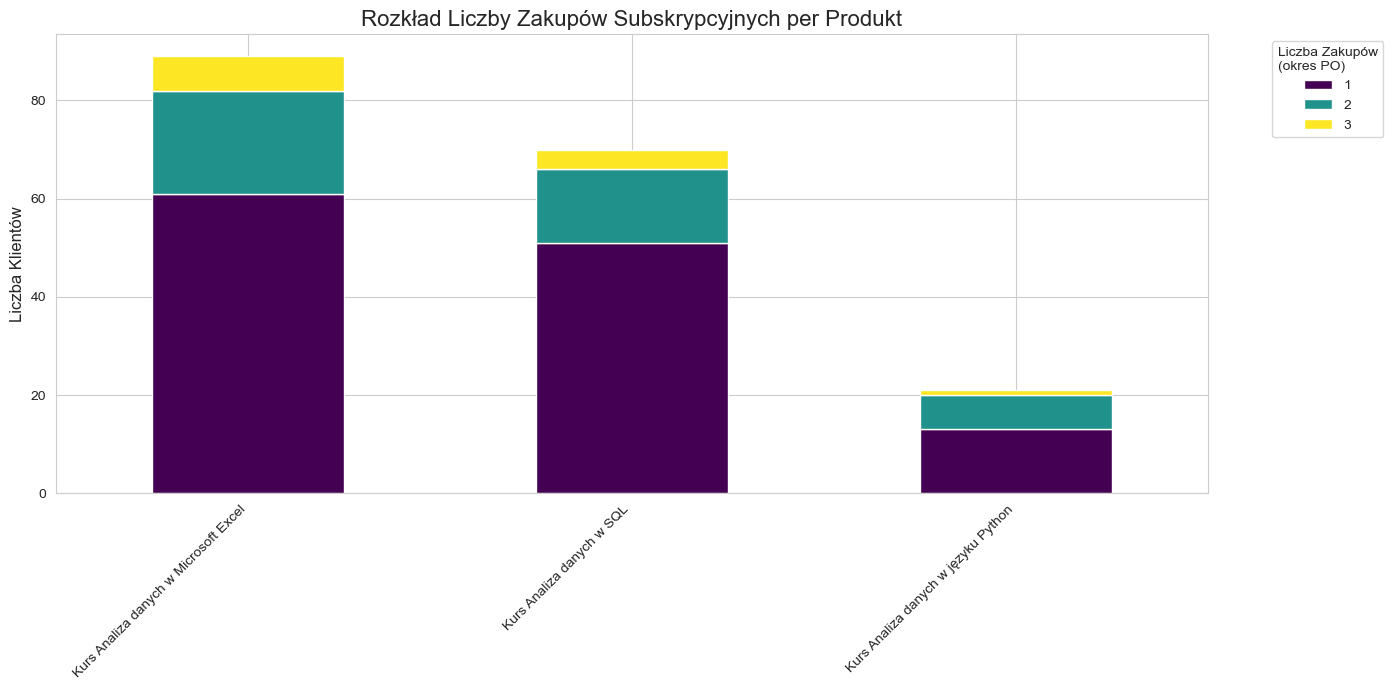

In [352]:
print("\nGenerowanie wykresu słupkowego skumulowanego dla rozkładu liczby zakupów subskrypcyjnych per produkt.")

df_viz_data = product_purchase_count_distribution_df_sorted.copy()

# --- Krok 1: Przygotowanie danych do wykresu słupkowego skumulowanego (Pivotowanie) ---
# Chcemy, żeby:
# - Index: product_customer
# - Kolumny: Subscription_Count_After_Split (np. 1, 2, 3)
# - Wartości: Number_of_Customers
pivot_table_counts = df_viz_data.pivot(
    index='product_customer',           # Kolumna, która stanie się indeksem
    columns='Purchase_Count', # Kolumna, której unikalne wartości staną się nazwami kolumn
    values='Number_of_Customers'        # Kolumna, której wartości wypełnią tabelę
)

# Po pivotowaniu mogą pojawić się wartości NaN, jeśli dany produkt nie miał klientów z określoną liczbą zakupów.
# Wypełniamy je zerami, bo 0 klientów dla tej kombinacji oznacza 0 na wykresie.
pivot_table_counts = pivot_table_counts.fillna(0)

# Opcjonalnie: Upewniamy się, że kolumny (liczba zakupów) są posortowane numerycznie
# Domyślnie mogą być posortowane jako stringi ('1', '10', '2'). Konwertujemy na int i sortujemy kolumny.
pivot_table_counts.columns = pivot_table_counts.columns.astype(int) # Konwertujemy nazwy kolumn na int
pivot_table_counts = pivot_table_counts.sort_index(axis=1) # Sortujemy kolumny numerycznie


print("\nDane po pivotowaniu (gotowe do wykresu słupkowego skumulowanego):")
print(pivot_table_counts.head())
print("...")


# --- Krok 2: Tworzenie wykresu słupkowego skumulowanego (dla liczby klientów) ---
sns.set_style("whitegrid") # Ustawiamy styl z Seaborn

plt.figure(figsize=(14, 7)) # Ustawiamy rozmiar figury
ax = pivot_table_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis') # Tworzymy wykres

# Dodajemy tytuły i etykiety
plt.title('Rozkład Liczby Zakupów Subskrypcyjnych per Produkt', fontsize=16)
plt.xlabel("")
plt.ylabel('Liczba Klientów', fontsize=12)
plt.xticks(rotation=45, ha='right') # Obracamy etykiety produktów na osi X dla czytelności

# Dostosowujemy legendę (pokazuje liczby zakupów i ich kolory)
plt.legend(title='Liczba Zakupów\n(okres PO)', bbox_to_anchor=(1.05, 1), loc='upper left') # Umieszczamy legendę poza wykresem

plt.tight_layout() # Automatycznie dopasowuje elementy wykresu
plt.show()

### Wnioski

- Analiza ta będzie miała większy sens dla dłuższego okresu czasu
- Krótkoterminowo widać, że w większości są to subskrypcje na jeden miesiąc, ale widać już też, że pojawiają się przedłużenia tych subskrypcji dwu a nawet trzy-miesięczne. Natomiast do wyciągania wniosków wstrzymałbym się jeszcze przez jakiś czas.

# PODSUMOWANIE

## Ogólny wniosek:
Wprowadzenie subskypcji nie wpłynęło ani w negatywny ani w pozytywny sposób na krótkoterminowy przychód. Widoczny jest za to wzrost liczby transakcji. 

## Szczegółowe wnioski:
W krótkoterminowym okresie po wprowadzeniu subskrypcji nie widać wpływu na zmianę przychodu. Natomiast widać wzrost ilości transakcji po wprowadzeniu subskrypcji - w szczególności dla kursów dotyczących Excela oraz SQL-a
- Klienci po wprowadzeniu subskrypcji częściej wybierają taką formę zapłaty za kursy
- Wprowadzenie subskrypcji nie wpłynęło w żaden sposób na szybszy przyrost nowych użytkowników platformy KajoDataSpace - wzrost jest cały czas taki sam tzn. liniowy
- Przychód pochodzący z kursu Pythona po wprowadzeniu subskrypcji, jest widocznie mniejszy niż ten w stosunku do przychodu przed wprowadzeniem subskrypcji - należałoby na to zwrócić uwagę i zastanowić się ze strony biznesowej czy jest to powód do niepokoju, czy raczej wynika to z "rynku" tzn. ze specyfiki, że nasi kursanci zgodnie ze ścieżką nauki wybiorą Pythona jako narzędzie do analizy danych dopiero na końcu, czyli wtedy gdy zakończą naukę Excela oraz SQL.
- Przydatną analizą w przyszłości będzie zbadanie wskaźnika tego, jak długo dany klient subskrybował dany kurs - na ten moment nie można wyciągnać wniosków ze względu na zbyt krótki okres "po subskrypcyjny". Na tej podstawie będzie można porównać cenę jednorazową za dany kurs vs średnia cena jaką klient zapłacił w ciągu x miesięcy subskrypcji